## Preparation (40 points total)

* [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   
* [15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
* [15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling (50 points total)

* [20 points] Create a convolutional neural network to use on your data using tensorflow. 
* [20 points] Investigate at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the results of the CNNs. 
* [10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.   

## Exceptional Work (10 points total)

You have free reign to provide additional analyses.
One idea: Visualize the convolutional filters chosen by your CNN. Try to interpret some of their meanings.

In [3]:
from keras.datasets import cifar10
from keras.models import Sequential, Input, Model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import keras
import matplotlib.pyplot as plt
keras.__version__

Using TensorFlow backend.


'2.0.3'

In [7]:
l2_lambda = 0.0001

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = cifar10.load_class_names()
NUM_CLASSES = 10
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# datagen = ImageDataGenerator(featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     rotation_range=5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.
# )
# datagen.fit(x_train)

# # build model
# lenet = Sequential()
# lenet.add(Conv2D(filters=6,kernel_size=(5,5),
#                input_shape = (32,32,3), 
#                padding='valid', 
#                kernel_initializer='he_uniform', 
#                kernel_regularizer=l2(l2_lambda)))
# lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
# lenet.add(BatchNormalization())
# lenet.add(Activation("sigmoid"))
# lenet.add(Conv2D(filters=16,kernel_size=(5,5), 
#                padding='valid', 
#                kernel_initializer='he_uniform', 
#                kernel_regularizer=l2(l2_lambda)))
# lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
# lenet.add(BatchNormalization())
# lenet.add(Activation("sigmoid"))
# #lenet.add(Dropout(0.5))
# lenet.add(Conv2D(filters=120,kernel_size=(1,1), 
#                padding='valid', 
#                kernel_initializer='he_uniform', 
#                kernel_regularizer=l2(l2_lambda)))

# lenet.add(Flatten())
# lenet.add(Dense(84))
# lenet.add(Activation("sigmoid"))
# lenet.add(Dense(NUM_CLASSES))
# lenet.add(Activation('softmax'))
# lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
#                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
#                 metrics=['accuracy'])

# # the flow method yields batches of images indefinitely, with the given transofmrations
# lenet.fit_generator(datagen.flow(x_train, y_train_ohe, batch_size=128), 
#   steps_per_epoch=int(len(x_train)/128), # how many generators to go through per epoch
#   epochs=50, verbose=2,
#   validation_data=(x_test,y_test_ohe),
#   callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#  )

AttributeError: module 'keras.datasets.cifar10' has no attribute 'load_class_names'

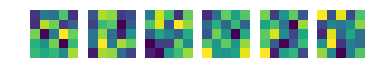

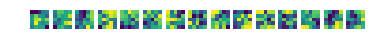

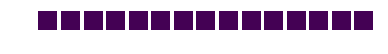

In [81]:
max_plots = 15
for layer in lenet.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()


In [5]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_2/MaxPool' (op: 'MaxPool') with input shapes: [?,1,16,64].